In [4]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from bs4 import BeautifulSoup
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier

In [5]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
py.init_notebook_mode(connected = True)

In [6]:
train = pd.read_csv('mbti_1.csv')
us = pd.read_csv('Users.csv')
ps = pd.read_csv('ForumMessages.csv')
mbti = {'I' : 'Introversion', 'E' : 'Extroversion', 'N' : 'Intutions', 'S' : 'Sensing', 'T' : 'Thinking', 'F' : 'Feeling', 'J': 'Judging', 'P' : 'Perceiving'}

FileNotFoundError: [Errno 2] No such file or directory: 'mbti_1.csv'

In [ ]:
train.shape

(8675, 2)

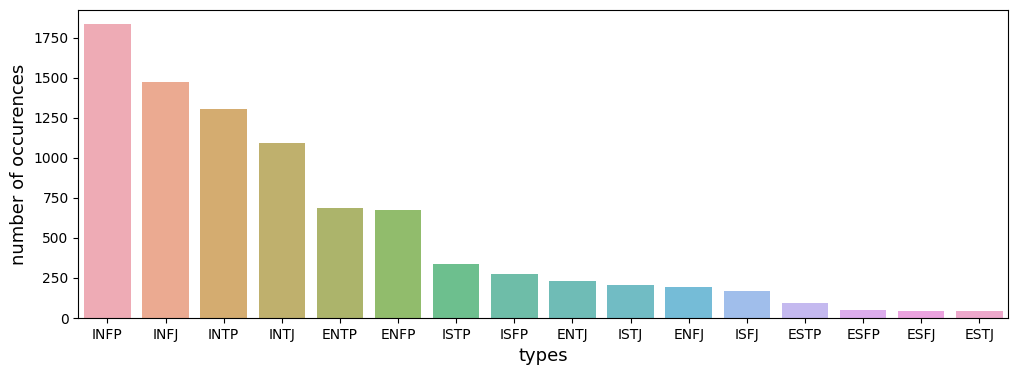

In [ ]:
cnt_srs = train['type'].value_counts()
plt.figure(figsize = (12,4))
sns.barplot(y = cnt_srs.values, x = cnt_srs.index, alpha=0.8)
plt.ylabel('number of occurences', fontsize = 13)
plt.xlabel('types', fontsize = 13)
plt.show()

In [ ]:
ps['Message'] = ps['Message'].fillna('')

In [ ]:
ps_join = ps.groupby('PostUserId')['Message'].agg(lambda col : ' '.join(col)).reset_index()

In [ ]:
etc = ExtraTreesClassifier(n_estimators = 20, max_depth = 4, n_jobs = -1)
tfidf = TfidfVectorizer(ngram_range = (1,1), stop_words = 'english')
tsvd = TruncatedSVD(n_components =10)
model = Pipeline([('tfidfi',tfidf),('tsvd1',tsvd),('etc',etc)])

In [ ]:
kfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

In [ ]:
np.random.seed(1)

scoring = {'acc' : 'accuracy',
          'neg_log_loss' : 'neg_log_loss',
          'f1_micro' : 'f1_micro'}

results = cross_validate(model, train['posts'], train['type'], cv = kfolds,
                        scoring = scoring, n_jobs = -1)


In [ ]:
print("CV Accuracy: {:0.4f}(+/- {:0.4f})".format(np.mean(results['test_acc']),
                                                np.std(results['test_acc'])))
print("CV F1: {:0.4f}(+/- {:0.4f})".format(np.mean(results['test_f1_micro']),
                                                np.std(results['test_f1_micro'])))
print("CV Logloss: {:0.4f}(+/- {:0.4f})".format(np.mean(results['test_neg_log_loss']),
                                                np.std(results['test_neg_log_loss'])))

CV Accuracy: 0.3047(+/- 0.0162)
CV F1: 0.3047(+/- 0.0162)
CV Logloss: -2.1351(+/- 0.0173)


In [ ]:
def cleanText(text):
    text = BeautifulSoup(text, 'lxml').text
    text = re.sub(r'\|\|\|',r'',text)
    text = re.sub(r'http\S+', r'<URL>',text)
    return text
                  

In [ ]:
train['clean_posts'] = train['posts'].apply(cleanText)

C:\Users\Jaydeep\AppData\Local\Temp\ipykernel_17260\2928371277.py:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [ ]:
print(repr(train.columns))

Index(['type', 'posts', 'clean_posts'], dtype='object')


In [ ]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range=(1,1),
                        stop_words='english',
                        lowercase = True,
                        max_features = 5000)

model_nb = Pipeline([('tfidf1', tfidf2), ('nb', MultinomialNB())])

results_nb = cross_validate(model_nb, train['clean_posts'], train['type'], cv=kfolds,
                           scoring=scoring, n_jobs = -1)

In [ ]:
print("CV Accuracy: {:0.4f}(+/- {:0.4f})".format(np.mean(results_nb['test_acc']),
                                                np.std(results_nb['test_acc'])))

print("CV F1: {:0.4f}(+/- {:0.4f})".format(np.mean(results_nb['test_f1_micro']),
                                                np.std(results_nb['test_f1_micro'])))

print("CV Logloss: {:0.4f}(+/- {:0.4f})".format(np.mean(-1*results_nb['test_neg_log_loss']),
                                                np.std(-1*results_nb['test_neg_log_loss'])))

CV Accuracy: 0.5622(+/- 0.0114)
CV F1: 0.5622(+/- 0.0114)
CV Logloss: 6.1920(+/- 0.3672)


In [ ]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range=(1,1), stop_words='english',
                                                lowercase = True, max_features = 5000)

model_lr = Pipeline([('tfidf1',tfidf2), ('lr',LogisticRegression(class_weight="balanced", C=0.005))])

results_lr = cross_validate(model_lr, train['clean_posts'], train['type'], cv=kfolds, 
                           scoring=scoring, n_jobs=-1)


In [ ]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_acc']),
                                                 np.std(results_lr['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_f1_micro']),
                                           np.std(results_lr['test_f1_micro'])))

print("CV LogLoss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_lr['test_neg_log_loss']),
                                                np.std(-1*results_lr['test_neg_log_loss'])))


CV Accuracy: 0.6552 (+/- 0.0134)
CV F1: 0.6552 (+/- 0.0134)
CV LogLoss: 1.3080 (+/- 0.0125)


In [ ]:
train_sizes, train_scores, test_scores = \
    learning_curve(model_lr, train['clean_posts'], train['type'], cv=kfolds, n_jobs=-1,
                  scoring = 'f1_micro', train_sizes = np.linspace(.1,1.0,10), random_state = 1)

In [ ]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):
    
    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color ="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
            label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
            label = "Cross-validation score")
    
    plt.legend(loc = "best")
    return plt


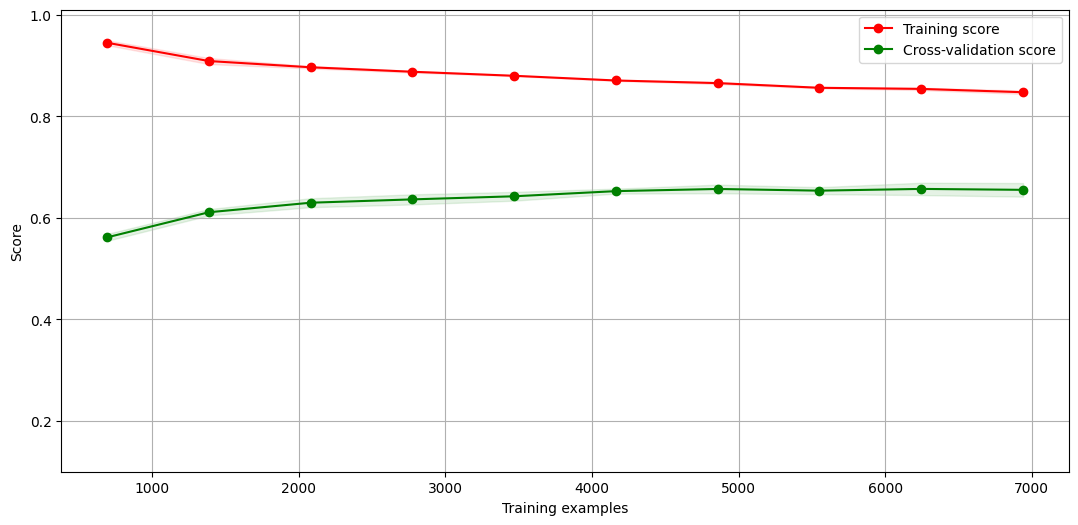

In [ ]:
plot_learning_curve(train['posts'],train['type'],train_sizes,
                   train_scores, test_scores, ylim=(0.1,1.01), figsize=(13,6))
plt.show()

In [ ]:
ps_join['clean_comments']= ps_join['Message'].apply(cleanText)

C:\Users\Jaydeep\AppData\Local\Temp\ipykernel_17260\2928371277.py:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [ ]:
model_lr.fit(train['clean_posts'], train['type'])
pred_all = model_lr.predict(ps_join['clean_comments'])

C:\Users\Jaydeep\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



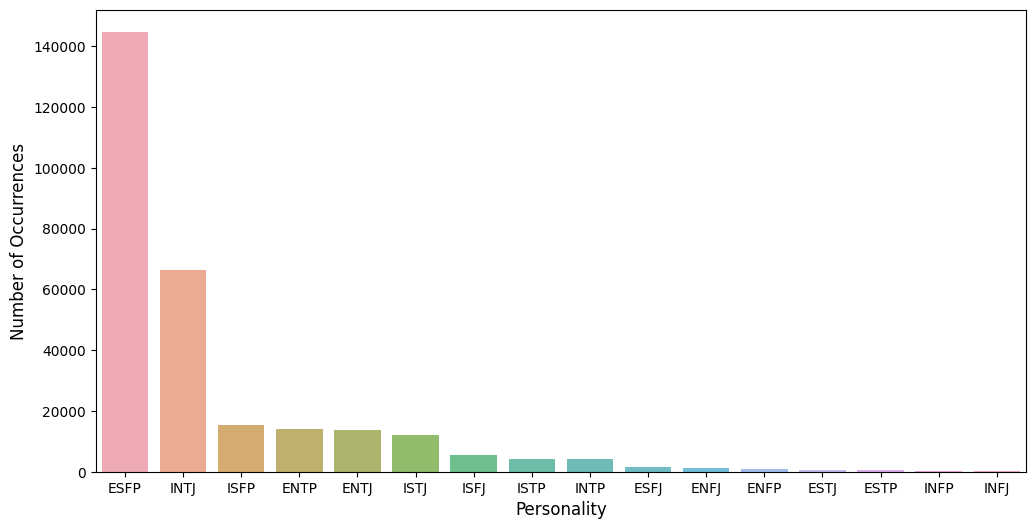

In [ ]:
cnt_all = np.unique(pred_all, return_counts=True)

pred_df = pd.DataFrame({'personality': cnt_all[0],'count': cnt_all[1]},
                      columns=['personality', 'count'], index=None)

pred_df.sort_values('count',ascending=False, inplace=True)

plt.figure(figsize=(12,6))
sns.barplot(x=pred_df['personality'], y=pred_df['count'], alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Personality',fontsize=12)
plt.show()


In [ ]:
pred_df['percent']=pred_df['count']/pred_df['count'].sum()

In [ ]:
pred_df['description']= pred_df['personality'].apply(lambda x: " ".join([mbti[l] for l in list(x)]))

In [ ]:
pred_df

,personality,count,percent,description
5,ESFP,144845,0.505798,Extroversion Sensing Feeling Perceiving
10,INTJ,66435,0.231991,Introversion Intutions Thinking Judging
13,ISFP,15302,0.053435,Introversion Sensing Feeling Perceiving
3,ENTP,14198,0.049579,Extroversion Intutions Thinking Perceiving
2,ENTJ,13814,0.048238,Extroversion Intutions Thinking Judging
14,ISTJ,12036,0.042030,Introversion Sensing Thinking Judging
12,ISFJ,5651,0.019733,Introversion Sensing Feeling Judging
15,ISTP,4302,0.015023,Introversion Sensing Thinking Perceiving
11,INTP,4238,0.014799,Introversion Intutions Thinking Perceiving
4,ESFJ,1471,0.005137,Extroversion Sensing Feeling Judging


In [ ]:
labels = pred_df['description']
sizes = pred_df['percent']*100

trace = go.Pie(labels = labels, values= sizes)
layout = go.Layout(
     title='Kaggle user personality distribution')

data = [trace]
fig = go.Figure(data= data, layout = layout)
py.iplot(fig)